# Importació de patrons

Els tipus de patrons minats han estat els generadors, ja que tenen el mateix suport que els closest però contenen menys items, prevenint redundància i overfitting. No obstant, el conjunt de patrons generadors és idèntic al dels closest fins a suports inferiors a 0.2 i per fer aquest experiment s'ha establert un suport mínim>=0.3.

In [1]:
file_path = "obese_defme.txt"

In [2]:
import re
import pandas as pd

Carreguem els patrons freqüents de la classe *obese* amb un suport>=0.3 i els guardem en un set de frozensets:

In [4]:
with open(file_path, 'r') as file:
    lines = file.read().splitlines()
    
obese_set=set()
for line in lines:
    pattern = re.split(r'#', line, 1)[0]
    row=pattern.split()
    obese_set.add(frozenset([*map(int,row)]))

print(f'Total patrons obesos: {len(obese_set)}')

Total patrons obesos: 2514


Carreguem els patrons freqüents de la classe *not obese* amb un suport>=0.3

In [5]:
file_path = "notobese_defme.txt"

In [6]:
with open(file_path, 'r') as file:
    lines = file.read().splitlines()
    
notobese_set=set()
for line in lines:
    pattern = re.split(r'#', line, 1)[0]
    row=pattern.split()
    #if len(row)>0:
    notobese_set.add(frozenset([*map(int,row)]))

print(f'Total patrons sans: {len(notobese_set)}')

Total patrons sans: 1777


Calculem la diferència simètrica dels dos conjunts, ens interessen els patrons freqüents característics de cada classe, per tant no poden aparèixer a la classe contraria:

In [9]:
symmetric_diff = obese_set.symmetric_difference(notobese_set)
print(len(symmetric_diff))
obese = [list(pattern) for pattern in obese_set] #llista patrons obesos
notobese = [list(pattern) for pattern in notobese_set] #llista patrons sans

patterns = [list(pattern) for pattern in symmetric_diff] #llista patrons diferència simètrica

2569


Comprovem com cada patró de la llista patterns és característic d'una única classe:

In [10]:
for i in range(10):
    print(f'Patró {patterns[i]}, Sa: {patterns[i] in notobese}, Obés: {patterns[i] in obese}')#primer patró forma part dels obesos

Patró [233, 43, 101], Sa: False, Obés: True
Patró [43, 31, 111], Sa: True, Obés: False
Patró [224, 21], Sa: False, Obés: True
Patró [144, 314, 123], Sa: False, Obés: True
Patró [314, 123, 21], Sa: False, Obés: True
Patró [161, 123, 62, 191], Sa: True, Obés: False
Patró [191, 123, 222, 31], Sa: True, Obés: False
Patró [123, 314, 51, 21], Sa: False, Obés: True
Patró [304, 123, 51], Sa: False, Obés: True
Patró [201, 92, 101, 191], Sa: True, Obés: False


Carreguem el DF amb els valors discretitzats:

In [11]:
data=pd.read_csv('output_d.csv')
data.head()

,AgeM,talla_EM,tabac_preM,alcohol_preM,BWM,Parity_EM,BMIpre_mare,AgeP,HeightP,BMI_P,...,mesos alim_mat_nen,Pes 2m_nen,Alçada 2m_nen,Pes 4m_nen,Alçada 4m_nen,pes 6m_nen,alçada 6m_nen,pes 12m_nen,alçada 12m_nen,OBE1TY_5Y_grup
0,3,12,21,31,43,51,63,74,83,93,...,264,274,282,293,302,312,323,333,341,1
1,1,13,22,31,42,51,62,71,82,92,...,261,272,282,292,301,312,322,332,342,0
2,2,14,21,31,43,51,63,74,83,93,...,261,272,284,293,304,313,324,333,344,0
3,4,12,21,31,43,52,62,74,83,94,...,264,272,283,293,303,313,323,334,344,1
4,3,13,21,31,43,51,62,73,84,92,...,262,272,283,292,302,312,323,332,342,0


Creem un diccionari amb el format {instància: [items]}

In [16]:
d={idx:list(row.values) for idx, row in data.iterrows()}#diccionari, {instància:[items]}
print(len(d))

386


Sabem que una instància compleix un patrò si el patró és un subset dels valors discretitzats de la instància.
Creem una llista **instances** de subllistes, la posició a la llista indica l'índex del patró i els valors de la subllista són les instàncies que el compleixen.

In [18]:
instances=[]
for p in patterns:
    instances.append([key for key, value in d.items() if set(p).issubset(value)])#[[instàncies que compleixen patró 1],...]
print(len(instances))
strings=[('pattern'+str(i)) for i in range(len(instances))]#[['pattern0'],['pattern1']]
print(len(strings))

2569
2569


In [19]:
print(len(instances[0]))#primer patró és complert per 56 instàncies

56


Afegim al dataset discretitzat les variables binàries que corresponen als patrons:
- 1 si la instància compleix el patró
- 0 si no el compleix  

In [20]:
import warnings
warnings.filterwarnings('ignore')
for pattern in range(len(strings)):#iterem tots els patrons
    for instance in instances[pattern]:#iterem totes les intàncies del patró
        data.loc[instance,strings[pattern]] = 1 #Creem la columna pattern# i afegim un 1 a cada instància que la compleix.

data.head()#2569 patrons + 35 variables + 1 target = 2605 columnes

,AgeM,talla_EM,tabac_preM,alcohol_preM,BWM,Parity_EM,BMIpre_mare,AgeP,HeightP,BMI_P,...,pattern2559,pattern2560,pattern2561,pattern2562,pattern2563,pattern2564,pattern2565,pattern2566,pattern2567,pattern2568
0,3,12,21,31,43,51,63,74,83,93,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN
1,1,13,22,31,42,51,62,71,82,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,14,21,31,43,51,63,74,83,93,...,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,4,12,21,31,43,52,62,74,83,94,...,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
4,3,13,21,31,43,51,62,73,84,92,...,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN


In [21]:
strings.append('OBE1TY_5Y_grup')
len(strings)

2570

In [22]:
data[strings].head()

,pattern0,pattern1,pattern2,pattern3,pattern4,pattern5,pattern6,pattern7,pattern8,pattern9,...,pattern2560,pattern2561,pattern2562,pattern2563,pattern2564,pattern2565,pattern2566,pattern2567,pattern2568,OBE1TY_5Y_grup
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0
3,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,1
4,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,0


In [23]:
data[strings].fillna(0).to_csv('patterns.csv', index=False)#dataset de patrons

# Pattern selection

In [28]:
from mrmr import mrmr_classif
import pandas as pd
import numpy as np
#from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_validate, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
data=pd.read_csv('patterns.csv')
data.head()

,pattern0,pattern1,pattern2,pattern3,pattern4,pattern5,pattern6,pattern7,pattern8,pattern9,...,pattern2560,pattern2561,pattern2562,pattern2563,pattern2564,pattern2565,pattern2566,pattern2567,pattern2568,OBE1TY_5Y_grup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0


In [26]:
target='OBE1TY_5Y_grup'
y=data[target]

In [27]:
cols=list(data.columns)
cols.remove(target)
X=data[cols]
len(cols)

2569

Calculem la puntuació de cada patró freqüent segons l'algorisme minimum redundancy maximum relevance.

In [29]:
selected_features = mrmr_classif(X, y, K = 200,relevance="rf",return_scores=False) #algorisme minimum redundancy maximum relevance

100%|██████████| 200/200 [00:29<00:00,  6.71it/s]


# Experiment 1: Leave 2 out CV

In [26]:
data.head()

,pattern0,pattern1,pattern2,pattern3,pattern4,pattern5,pattern6,pattern7,pattern8,pattern9,...,pattern2560,pattern2561,pattern2562,pattern2563,pattern2564,pattern2565,pattern2566,pattern2567,pattern2568,OBE1TY_5Y_grup
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0


In [ ]:
idx_positives=data[data['OBE1TY_5Y_grup']==1].index
idx_negatives=data[data['OBE1TY_5Y_grup']==0].index
dt = DecisionTreeClassifier()
LPOCV = {}
std = {}
for i in np.arange(1,41,1):
    counter = 0
    scores = np.zeros(17928)
    for p in idx_positives:
        for n in idx_negatives:
            X_train=data[~data.index.isin([p, n])][selected_features[:i]].values
            y_train=data[~data.index.isin([p, n])]['OBE1TY_5Y_grup'].values.reshape(-1,1)
            X_test=data[data.index.isin([p, n])][selected_features[:i]].values
            y_test=data[data.index.isin([p, n])]['OBE1TY_5Y_grup'].values.reshape(-1,1)
            dt.fit(X_train, y_train)
            y_pred = dt.predict(X_test)
            scores[counter]=accuracy_score(y_test, y_pred)
            counter += 1
    LPOCV[i]=round(np.mean(scores),2)
    std[i]=round(np.std(scores),2)

In [ ]:
# Create a DataFrame from the data
dic_lpocv = {'Iteration': LPOCV.keys(), 'Mean Value': LPOCV.values(), 'Standard Deviation': std.values()}
df_lpocv = pd.DataFrame(dic_lpocv)

In [57]:
df_lpocv.to_csv('lopcv.csv', index=False)

In [2]:
df_lpocv = pd.read_csv('lopcv.csv')
df_lpocv.head()

,Iteration,Mean Value,Standard Deviation
0,1,0.50,0.00
1,2,0.49,0.08
2,3,0.50,0.14
3,4,0.49,0.17
4,5,0.53,0.15


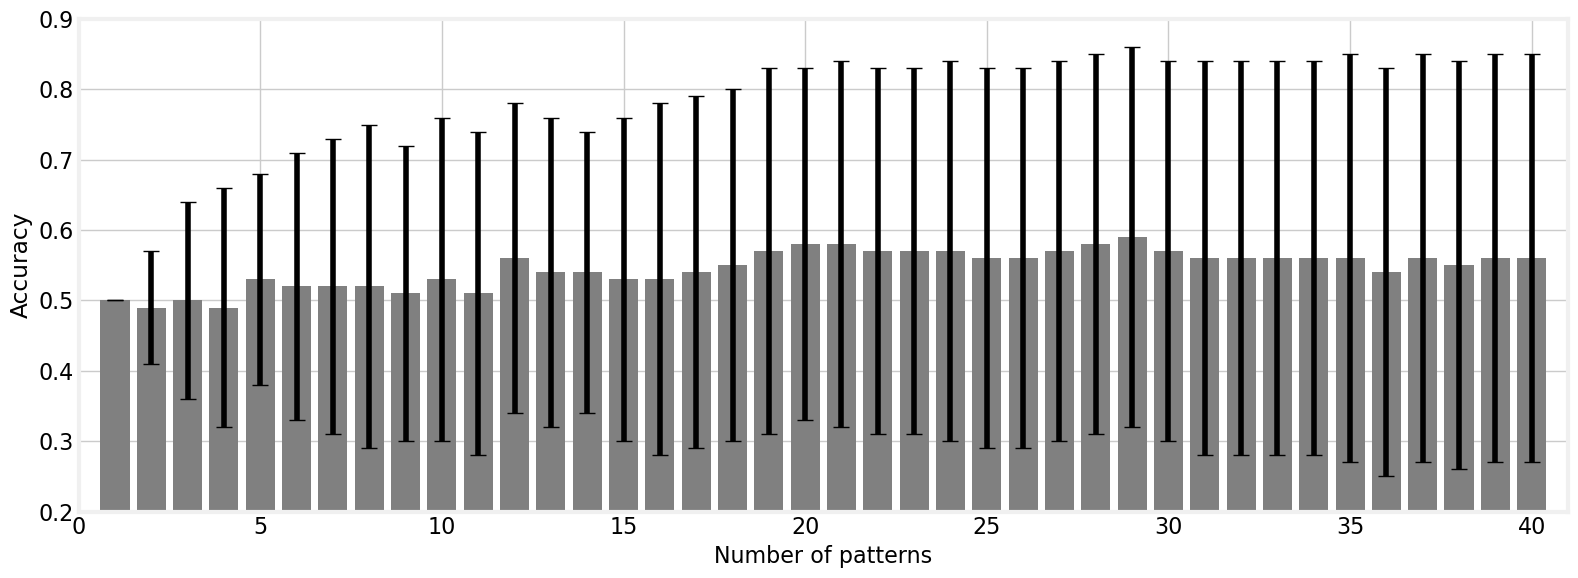

In [3]:
plt.style.use('fivethirtyeight')
x = df_lpocv['Iteration']
y = df_lpocv['Mean Value']
errorbars = df_lpocv['Standard Deviation'].values
fig, ax = plt.subplots(figsize=(16,6)) 
plt.bar(x,y,color='gray')
for i, bar in enumerate(ax.patches):
    bar_width = bar.get_width()
    bar_center = bar.get_x()
    ax.errorbar(bar_center + bar.get_width() / 2, bar.get_height(), yerr=errorbars[i], color='black', capsize=6)
plt.tick_params(labelsize=16)
plt.xlabel('Number of patterns',fontsize=16)
plt.ylabel('Accuracy')
plt.ylim(0.2, 0.9)
plt.xlim(left=0,right=41)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.tight_layout()
fig.savefig('LOPCV.png',dpi=300)
plt.show()

# Experiment 2: 5-Fold CV (dataset patrons)

Instanciem un *DecisionTreeClassifier* i anem afegint patrons freqüents gradualment alhora que calculant-ne el *recall* = tp / (tp + fn) i l'*accuracy* = (tp+tn)/(tp+tn+fp+fn). Ens interessa la mètrica recall ja que volem minimitzar els falsos negatius. intentant aconseguir una reducció petita en accuracy (% de prediccions correctes).

In [28]:
recall, accuracy, precision, f1, roc_auc = {}, {}, {}, {}, {}#tp/(tp+fn)
dt = DecisionTreeClassifier()#es el que millor recall dona.
kf=StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

for i in np.arange(1,101,1):
  X=data[selected_features[:i]]
  c_validate = cross_validate(dt, X, y, cv=kf,scoring=['recall','precision','accuracy','f1','roc_auc'])
  recall[i]=round(c_validate['test_recall'].mean(),2)
  precision[i]=round(c_validate['test_precision'].mean(),2)
  accuracy[i]=round(c_validate['test_accuracy'].mean(),2)
  f1[i]=round(c_validate['test_f1'].mean(),2)
  roc_auc[i]=round(c_validate['test_roc_auc'].mean(),2)

print('Number of features with maximum recall: {}'.format(max(recall, key=recall.get)))#maxim numero de patrons inclosos
print('Maximum recall: {:.2f}'.format(recall[max(recall, key=recall.get)]))#maxim recall
print('Number of features with maximum precision: {}'.format(max(precision, key=precision.get)))#maxim numero de patrons inclosos
print('Maximum precision: {:.2f}'.format(precision[max(precision, key=precision.get)]))#maxim precision
print('Number of features with maximum accuracy: {}'.format(max(accuracy, key=accuracy.get)))#maxim numero de patrons inclosos
print('Maximum accuracy: {:.2f}'.format(accuracy[max(accuracy, key=accuracy.get)]))#maxim accuracy
print('Number of features with maximum f1: {}'.format(max(f1, key=f1.get)))#maxim numero de patrons inclosos
print('Maximum f1: {:.2f}'.format(f1[max(f1, key=f1.get)]))#maxim f1
print('Number of features with maximum roc_auc: {}'.format(max(roc_auc, key=roc_auc.get)))#maxim numero de patrons inclosos
print('Maximum roc_auc: {:.2f}'.format(roc_auc[max(roc_auc, key=roc_auc.get)]))#maxim roc_auc

Number of features with maximum recall: 43
Maximum recall: 0.52
Number of features with maximum precision: 3
Maximum precision: 0.80
Number of features with maximum accuracy: 4
Maximum accuracy: 0.88
Number of features with maximum f1: 43
Maximum f1: 0.49
Number of features with maximum roc_auc: 5
Maximum roc_auc: 0.80


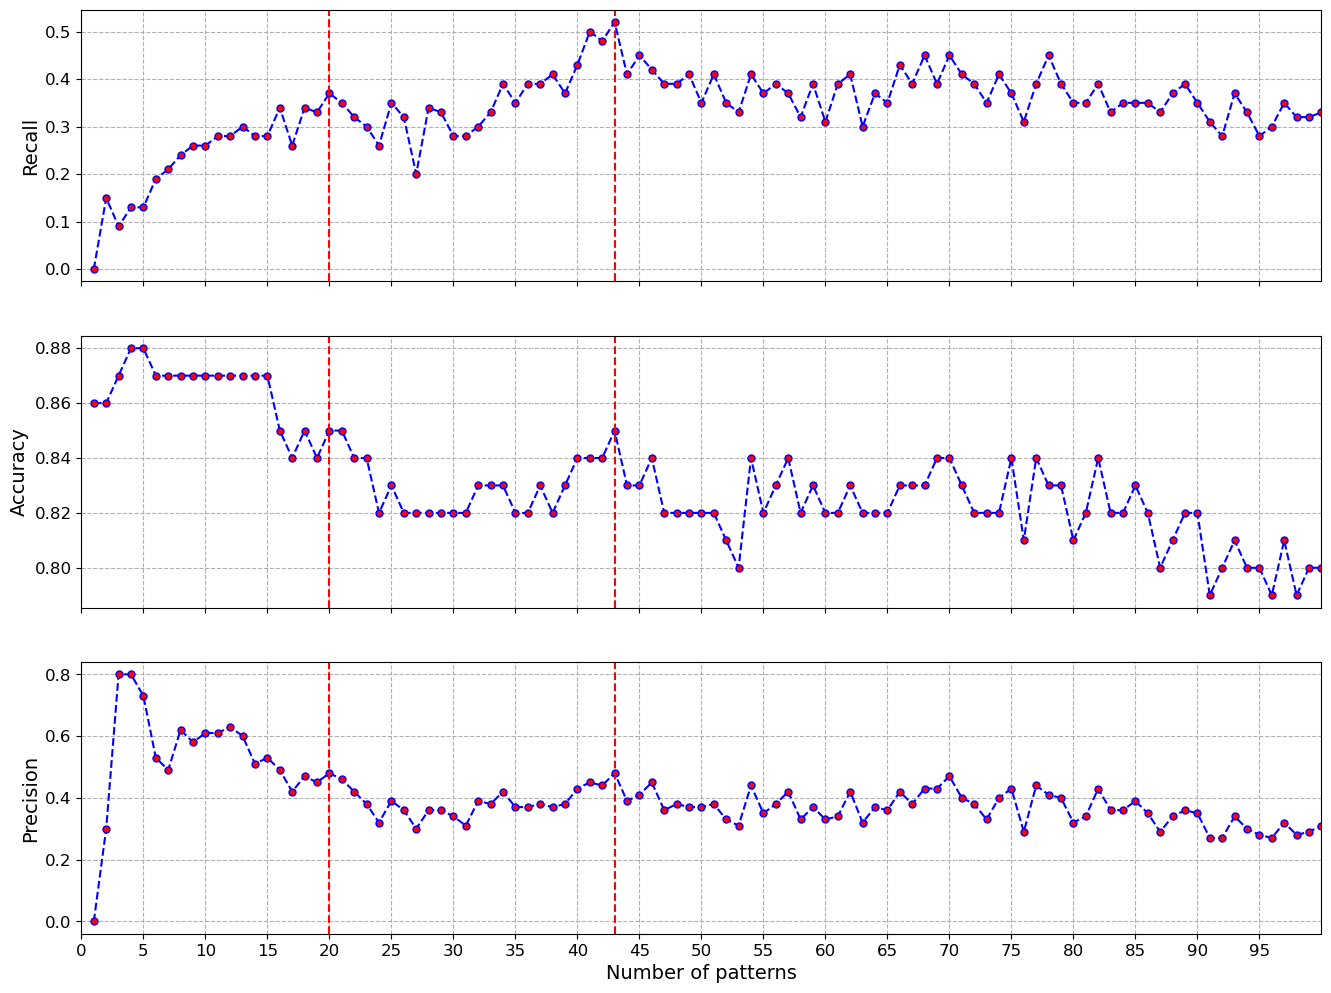

In [158]:
plt.style.use('default')
fig, ax = plt.subplots(3,1,figsize=(16,12),sharex=True)

ax[0].plot(recall.keys(),recall.values(),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)

ax[1].plot(accuracy.keys(),accuracy.values(),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)

ax[2].plot(precision.keys(),precision.values(),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)

ax[0].axvline(x=20, color='red', linestyle='--')
ax[1].axvline(x=20, color='red', linestyle='--')
ax[2].axvline(x=20, color='red', linestyle='--')
ax[0].axvline(x=43, color='red', linestyle='--')
ax[1].axvline(x=43, color='red', linestyle='--')
ax[2].axvline(x=43, color='red', linestyle='--')

ax[0].set_ylabel('Recall',fontsize=14)
ax[1].set_ylabel('Accuracy',fontsize=14)
ax[2].set_ylabel('Precision',fontsize=14)
ax[2].set_xticks(range(0, 100, 5))
ax[2].set_xlabel('Number of patterns',fontsize=14)

ax[0].set_xlim(left=0,right=100)
ax[1].set_xlim(left=0,right=100)
ax[2].set_xlim(left=0,right=100)

ax[0].grid(True, linestyle='--')
ax[1].grid(True, linestyle='--')
ax[2].grid(True, linestyle='--')

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[2].tick_params(labelsize=12)

fig.savefig('Experiment1.png',dpi=300)
plt.show()

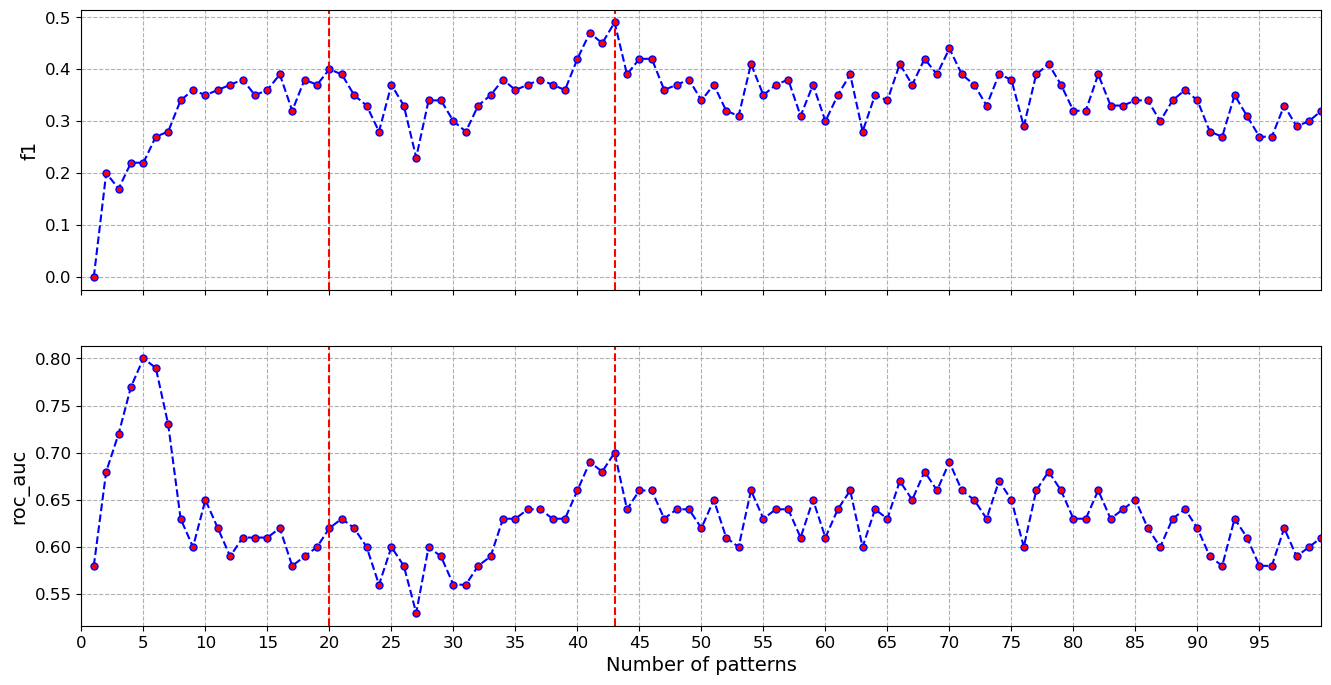

In [159]:
plt.style.use('default')
fig, ax = plt.subplots(2,1,figsize=(16,8),sharex=True)

ax[0].plot(f1.keys(),f1.values(),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)

ax[1].plot(roc_auc.keys(),roc_auc.values(),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)

ax[0].axvline(x=20, color='red', linestyle='--')
ax[1].axvline(x=20, color='red', linestyle='--')
ax[0].axvline(x=43, color='red', linestyle='--')
ax[1].axvline(x=43, color='red', linestyle='--')

ax[0].set_ylabel('f1',fontsize=14)

ax[1].set_ylabel('roc_auc',fontsize=14)

ax[1].set_xticks(range(0, 100, 5))
ax[1].set_xlabel('Number of patterns',fontsize=14)

ax[0].set_xlim(left=0,right=100)
ax[1].set_xlim(left=0,right=100)

ax[0].grid(True, linestyle='--')
ax[1].grid(True, linestyle='--')

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

fig.savefig('Experiment1_2.png',dpi=300)
plt.show()

Al voltant de 20 frequent patterns seria un valor adequat per tenir una bona compensació entre *recall* i *accuracy*.

Quin *recall* i *accuracy* podem esperar si seleccionem 20 *frequent patterns*? Calculem la CV score promig de *recall* i *accuracy* 386 vegades i en mostrem la distribució.

In [69]:
X=data[selected_features[:20]]
y=data[target]
recall_m, accuracy_m = [], []
dt=DecisionTreeClassifier()

for i in range(len(data)):
    kf=StratifiedKFold(n_splits=5, shuffle=True)
    X=data[selected_features[:20]]
    y=data[target]
    c_validate = cross_validate(dt, X, y, cv=kf,scoring=['recall','accuracy'])
    recall_m.append(round(c_validate['test_recall'].mean(),2))
    accuracy_m.append(round(c_validate['test_accuracy'].mean(),2))

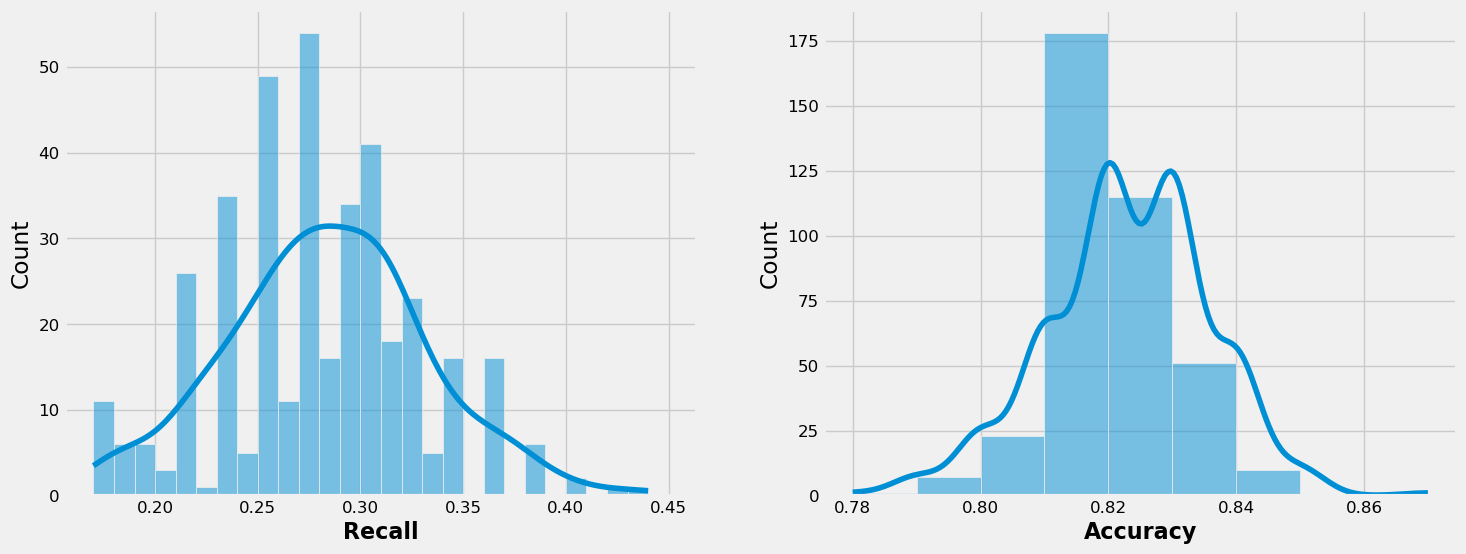

In [93]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.histplot(recall_m, kde=True,ax=ax[0], binwidth=0.01)
sns.histplot(accuracy_m, kde=True,ax=ax[1], binwidth=0.01)
ax[0].set_xlabel('Recall', fontweight='bold',fontsize=16)
ax[1].set_xlabel('Accuracy', fontweight='bold',fontsize=16)
ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
fig.savefig('histogram.png',dpi=300)
plt.show()

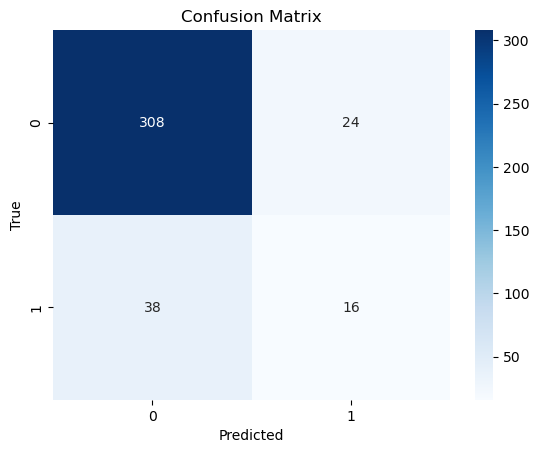

In [46]:
features=selected_features[:20]
X=data[features]

y_pred = cross_val_predict(dt, X, y, cv=5)#provides the predicted labels for each sample
cm = confusion_matrix(y, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)],
                  columns = [i for i in np.unique(y)])
plt.figure()
sns.heatmap(df_cm, annot=True,fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Si les dades que tenim son representatives de la població, podem esperar tenir recall~28 i accuracy~83. Així doncs, podem detectar 1 de cada 4 nens obesos utilitzant els 20 patrons més freqüents i discriminatius.

# Proves amb altres models

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [79]:
xgb = XGBClassifier()
rf = RandomForestClassifier()
svc = svm.SVC(kernel='linear')
lr = LogisticRegression()
recall_xgb, recall_rf, recall_svc, recall_lr = {}, {}, {}, {}
scoring = make_scorer(recall_score)
kf=StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
for i in np.arange(1,41,1):
  X=data[selected_features[:i]]
  c_validate = cross_val_score(xgb, X, y, cv=kf,scoring=scoring)
  recall_xgb[i]=round(c_validate.mean(),2)
  c_validate = cross_val_score(rf, X, y, cv=kf,scoring=scoring)
  recall_rf[i]=round(c_validate.mean(),2)
  c_validate = cross_val_score(svc, X, y, cv=kf,scoring=scoring)
  recall_svc[i]=round(c_validate.mean(),2)
  c_validate = cross_val_score(lr, X, y, cv=kf,scoring=scoring)
  recall_lr[i]=round(c_validate.mean(),2)


In [ ]:
models = {
            'Iteration': recall_xgb.keys(),
            'XGBoost': recall_xgb.values(),
            'RF': recall_rf.values(), 
            'SVC': recall_svc.values(),
            'LogisticR': recall_lr.values(),
            'Dtree': recall[:40],
        }
models = pd.DataFrame(models)

In [89]:
models.to_csv('recall_models.csv', index=False)

In [106]:
models = pd.read_excel('recall_models.xlsx')
models.head(10)

,Iteration,XGBoost,RF,SVC,LogisticR,Dtree
0,1,0.00,0.00,0.00,0.00,0.00
1,2,0.15,0.15,0.00,0.00,0.15
2,3,0.07,0.05,0.00,0.09,0.10
3,4,0.15,0.16,0.00,0.07,0.13
4,5,0.13,0.13,0.00,0.09,0.13
5,6,0.21,0.21,0.00,0.11,0.19
6,7,0.30,0.26,0.00,0.06,0.21
7,8,0.30,0.24,0.05,0.15,0.24
8,9,0.30,0.30,0.04,0.15,0.26
9,10,0.34,0.23,0.00,0.19,0.26


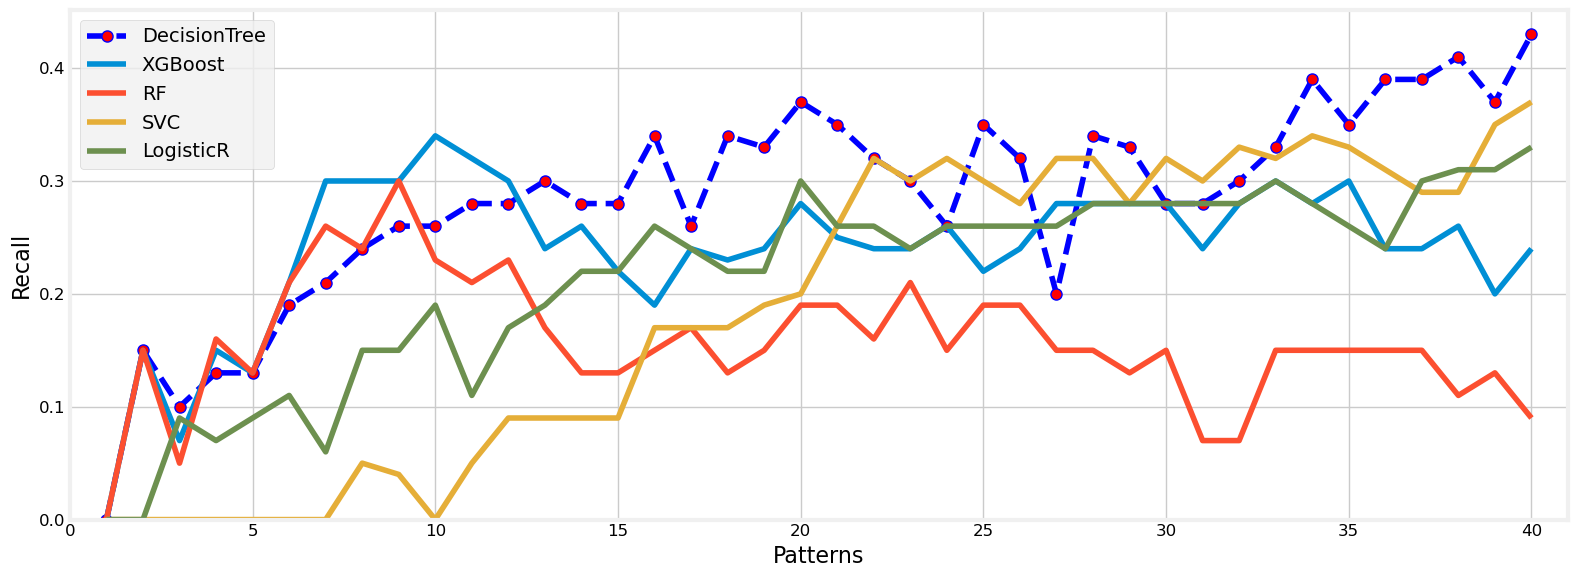

In [116]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(16,6))
x = models['Iteration']

plt.plot(x, models['Dtree'], label='DecisionTree', color= 'blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)

plt.plot(x, models['XGBoost'], linestyle='solid', label='XGBoost')

plt.plot(x, models['RF'], linestyle='solid', label='RF')

plt.plot(x, models['SVC'], linestyle='solid', label='SVC')

plt.plot(x, models['LogisticR'], linestyle='solid', label='LogisticR')

plt.ylabel('Recall',fontsize=16)
plt.xlabel('Patterns',fontsize=16)
plt.ylim(0)
plt.xlim(left=0,right=41)
plt.tick_params(labelsize=12)
plt.legend()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

plt.tight_layout()

plt.show()


# Experiment 3: 5-Fold CV (dataset numèric + patrons)

Carreguem el dataset original amb els *missing values* imputats.

In [74]:
df=pd.read_excel('output.xlsx')
df.head()

,AgeM,talla_EM,tabac_preM,alcohol_preM,BWM,Parity_EM,BMIpre_mare,AgeP,HeightP,BMI_P,...,mesos alim_mat_nen,Pes 2m_nen,AlÃ§ada 2m_nen,Pes 4m_nen,AlÃ§ada 4m_nen,pes 6m_nen,alÃ§ada 6m_nen,pes 12m_nen,alÃ§ada 12m_nen,OBE1TY_5Y_grup
0,35,160.0,0.0,0.0,3.0,1.0,26.56,46.0,178.0,27.12,...,8.0,5650.0,57.0,7140.0,62.5,7630.0,67.0,9750.0,73.0,1
1,19,164.0,1.0,0.0,2.0,1.0,23.80,26.0,173.0,24.75,...,2.0,5110.0,56.0,6390.0,61.0,7520.0,66.0,9380.0,74.0,0
2,30,170.0,0.0,0.0,3.0,1.0,29.07,44.0,178.0,25.56,...,3.0,5240.0,59.0,7110.0,68.0,8160.0,70.0,9880.0,78.5,0
3,36,163.0,0.0,0.0,3.0,2.0,21.45,42.0,178.0,30.93,...,9.0,5220.0,58.0,7070.0,64.0,8210.0,68.0,11440.0,77.0,1
4,32,165.0,0.0,0.0,3.0,1.0,20.75,38.0,182.0,23.25,...,5.0,5187.0,58.0,6428.0,63.0,7280.0,67.0,9200.0,74.0,0


In [76]:
numeric=list(df.columns)
numeric.remove(target)
X=df[numeric]
len(numeric)

35

Repetim el càlcul de les distribucions de *recall* i *accuracy* amb el dataset numèric sense afegir cap patró freqüent.

In [77]:
recall_means, accuracy_means = [], []
dt=DecisionTreeClassifier()

for i in range(len(df)):
    kf=StratifiedKFold(n_splits=5, shuffle=True)
    X=df[numeric]
    y=df[target]
    c_validate = cross_validate(dt, X, y, cv=kf,scoring=['recall','accuracy'])
    recall_means.append(round(c_validate['test_recall'].mean(),2))
    accuracy_means.append(round(c_validate['test_accuracy'].mean(),2))
    

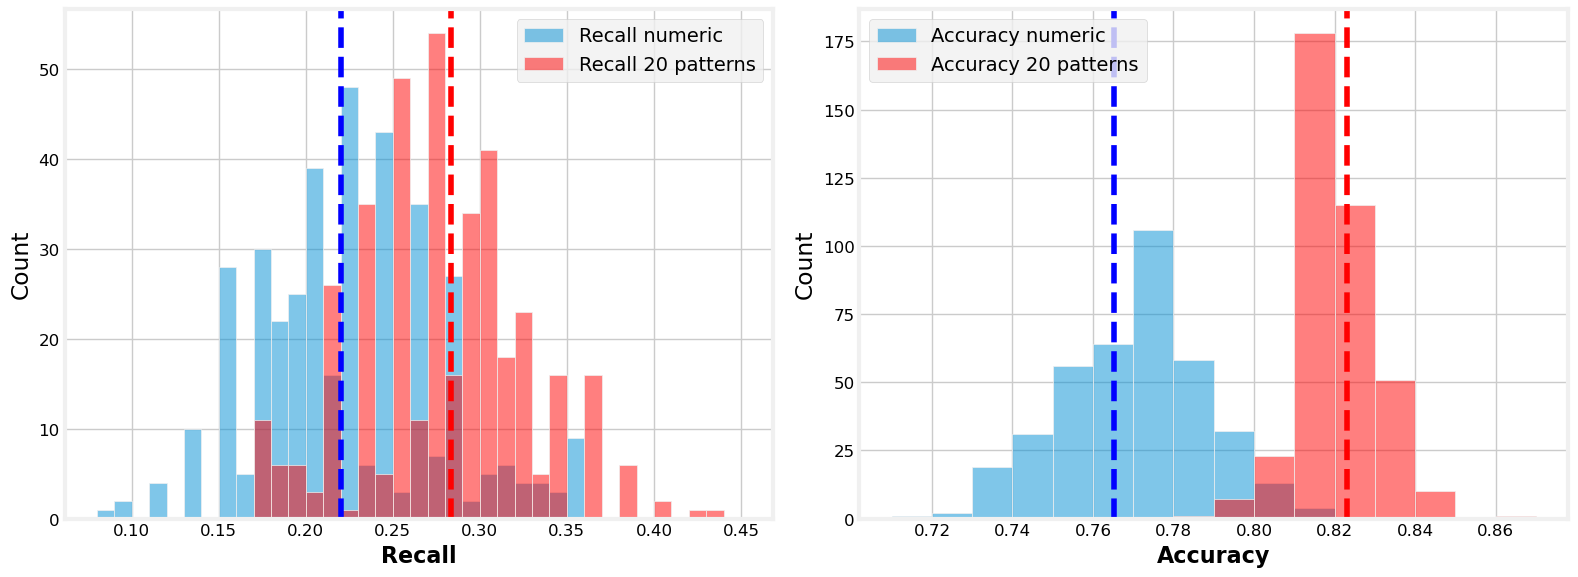

In [92]:
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.histplot(recall_means, kde=False,ax=ax[0], binwidth=0.01, label='Recall numeric', alpha=0.5)
sns.histplot(recall_m, kde=False,ax=ax[0], binwidth=0.01, label='Recall 20 patterns', alpha=0.5,color='red')
sns.histplot(accuracy_means, kde=False,ax=ax[1], binwidth=0.01, label='Accuracy numeric', alpha=0.5)
sns.histplot(accuracy_m, kde=False,ax=ax[1], binwidth=0.01, label='Accuracy 20 patterns', alpha=0.5,color='red')

ax[0].axvline(np.mean(recall_means), color='blue', linestyle='--')#, label='Mean numeric')
ax[0].axvline(np.mean(recall_m), color='red', linestyle='--')#, label='Mean 20 patterns')
ax[1].axvline(np.mean(accuracy_means), color='blue', linestyle='--')#, label='Mean numeric')
ax[1].axvline(np.mean(accuracy_m), color='red', linestyle='--')#, label='Mean 20 patterns')

ax[0].set_xlabel('Recall', fontweight='bold',fontsize=16)
ax[1].set_xlabel('Accuracy', fontweight='bold',fontsize=16)

ax[0].legend()
ax[1].legend()

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

fig.patch.set_facecolor('white')
ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
plt.tight_layout()
fig.savefig('histogram2.png',dpi=300)
plt.show()

D'entrada podem dir, que utilitzant els patrons freqüents aconseguim més *recall* que utilitzant les variables numèriques, això confirma el poder discriminatiu dels patrons. I pel que fa a l'*accuracy*, el valor esperat obtingut utilitzant els patrons també és superior. 

Repetim el procés de l'experiment anterior, afegint patrons freqüents de manera gradual i calculant-ne l'*accuracy* i el *recall*.

In [76]:
X=df[numeric]
y=df[target]
recall_2={}
precision_2={}
accuracy_2={}
f1_2={}
roc_auc_2={}
dt = DecisionTreeClassifier()
kf=StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

for i in np.arange(1,101,1):
  patrons=data[selected_features[:i]]
  stacked = pd.concat([X, patrons], axis=1)
  c_validate = cross_validate(dt, stacked, y, cv=5,scoring=['recall','precision','accuracy','f1','roc_auc'])
  recall_2[i]=round(c_validate['test_recall'].mean(),2)
  precision_2[i]=round(c_validate['test_precision'].mean(),2)
  accuracy_2[i]=round(c_validate['test_accuracy'].mean(),2)
  f1_2[i]=round(c_validate['test_f1'].mean(),2)
  roc_auc_2[i]=round(c_validate['test_roc_auc'].mean(),2)

print('Number of features with maximum recall: {}'.format(max(recall_2, key=recall_2.get)))#maxim numero de patrons inclosos
print('Maximum recall: {:.2f}'.format(recall_2[max(recall_2, key=recall_2.get)]))#maxim recall
print('Number of features with maximum precision: {}'.format(max(precision_2, key=precision_2.get)))#maxim numero de patrons inclosos
print('Maximum precision: {:.2f}'.format(precision_2[max(precision_2, key=precision_2.get)]))#maxim precision
print('Number of features with maximum accuracy: {}'.format(max(accuracy_2, key=accuracy_2.get)))#maxim numero de patrons inclosos
print('Maximum accuracy: {:.2f}'.format(accuracy[max(accuracy_2, key=accuracy_2.get)]))#maxim accuracy
print('Number of features with maximum f1: {}'.format(max(f1_2, key=f1_2.get)))#maxim numero de patrons inclosos
print('Maximum f1: {:.2f}'.format(f1_2[max(f1, key=f1_2.get)]))#maxim f1
print('Number of features with maximum roc_auc: {}'.format(max(roc_auc_2, key=roc_auc_2.get)))#maxim numero de patrons inclosos
print('Maximum roc_auc: {:.2f}'.format(roc_auc[max(roc_auc_2, key=roc_auc_2.get)]))#maxim roc_auc

Number of features with maximum recall: 20
Maximum recall: 0.39
Number of features with maximum precision: 29
Maximum precision: 0.39
Number of features with maximum accuracy: 29
Maximum accuracy: 0.82
Number of features with maximum f1: 29
Maximum f1: 0.38
Number of features with maximum roc_auc: 29
Maximum roc_auc: 0.59


Afegint molts patrons arribem fins hi tot a valors propers al 40% en recall.

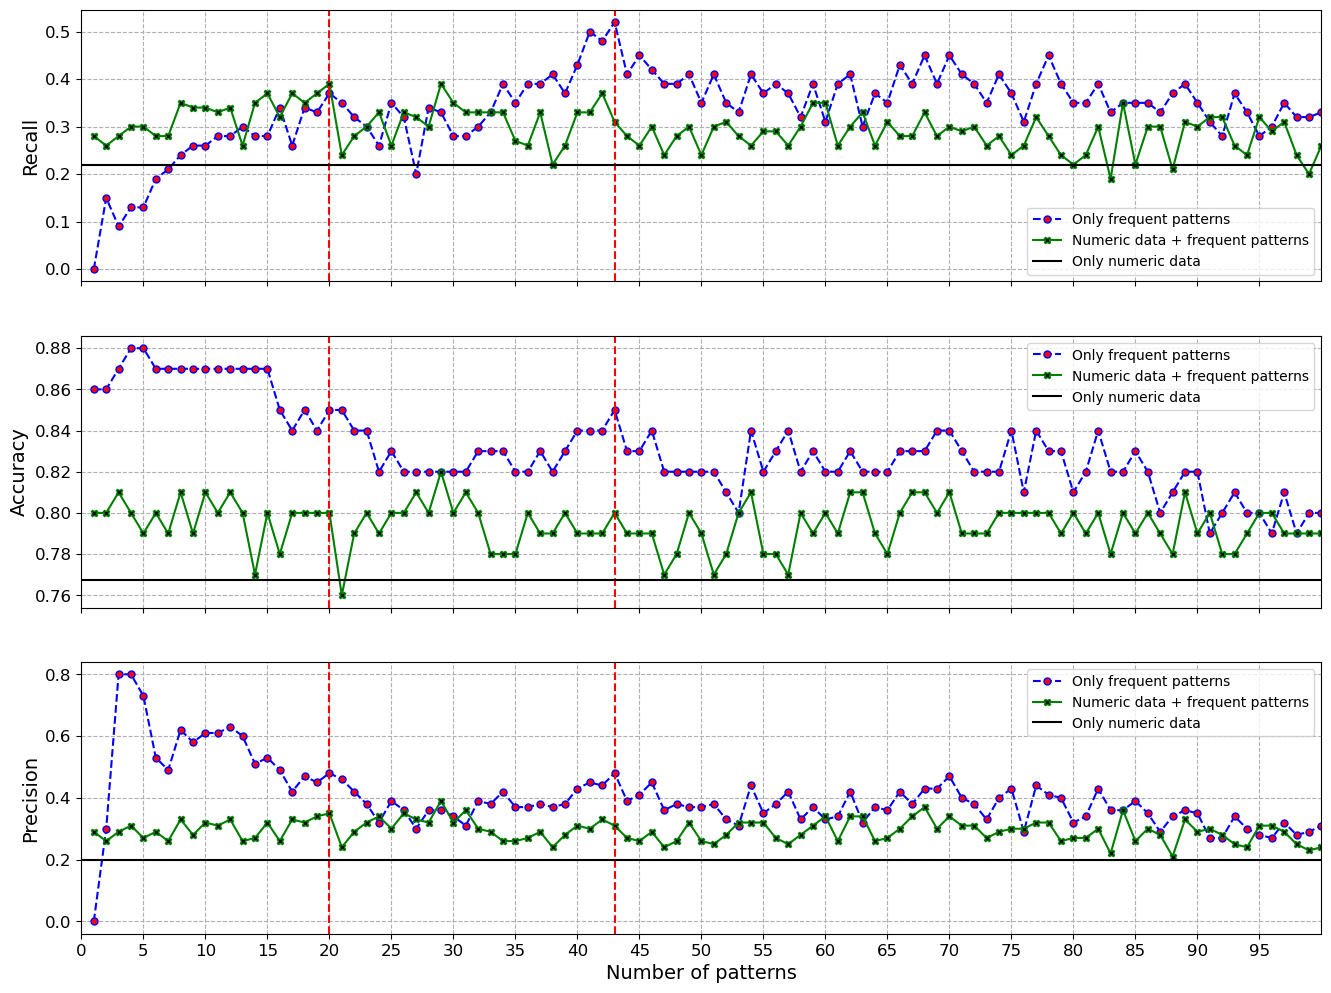

In [150]:
plt.style.use('default')
fig, ax = plt.subplots(3,1,figsize=(16,12),sharex=True)

ax[0].plot(recall.keys(),recall.values(),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5,label='Only frequent patterns')
ax[0].plot(recall_2.keys(),recall_2.values(),color='green', linestyle='-', marker='X',
         markerfacecolor='black', markersize=5,label='Numeric data + frequent patterns')
ax[1].plot(accuracy.keys(),accuracy.values(),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5,label='Only frequent patterns')
ax[1].plot(accuracy_2.keys(),accuracy_2.values(),color='green', linestyle='-', marker='X',
         markerfacecolor='black', markersize=5,label='Numeric data + frequent patterns')
ax[2].plot(precision.keys(),precision.values(),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5,label='Only frequent patterns')
ax[2].plot(precision_2.keys(),precision_2.values(),color='green', linestyle='-', marker='X',
         markerfacecolor='black', markersize=5,label='Numeric data + frequent patterns')

ax[0].axvline(x=20, color='red', linestyle='--')
ax[1].axvline(x=20, color='red', linestyle='--')
ax[2].axvline(x=20, color='red', linestyle='--')
ax[0].axvline(x=43, color='red', linestyle='--')
ax[1].axvline(x=43, color='red', linestyle='--')
ax[2].axvline(x=43, color='red', linestyle='--')

ax[0].axhline(y=np.mean(recall_means), color='black', linestyle='-', label='Only numeric data')
ax[1].axhline(y=np.mean(accuracy_means), color='black', linestyle='-', label='Only numeric data')
ax[2].axhline(y=np.mean(precision_means), color='black', linestyle='-', label='Only numeric data')

ax[0].set_ylabel('Recall',fontsize=14)
ax[1].set_ylabel('Accuracy',fontsize=14)
ax[2].set_ylabel('Precision',fontsize=14)
ax[2].set_xlabel('Number of patterns',fontsize=14)
ax[2].set_xticks(range(0, 100, 5))

ax[0].set_xlim(left=0,right=100)
ax[1].set_xlim(left=0,right=100)
ax[2].set_xlim(left=0,right=100)

ax[0].grid(True, linestyle='--')
ax[1].grid(True, linestyle='--')
ax[2].grid(True, linestyle='--')

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)
ax[2].tick_params(labelsize=12)

ax[0].legend()
ax[1].legend()
ax[2].legend()

fig.savefig('Experiment3.png',dpi=300)
plt.show()

A l'afegir patrons discriminatius al dataset original augmentem el *recall*, que passa de valors del 0.23 fins a valors propers al 0.4 afegint els primers 20-30 patrons, nivells de *recall* similars als aconseguits únicament amb els patrons. 

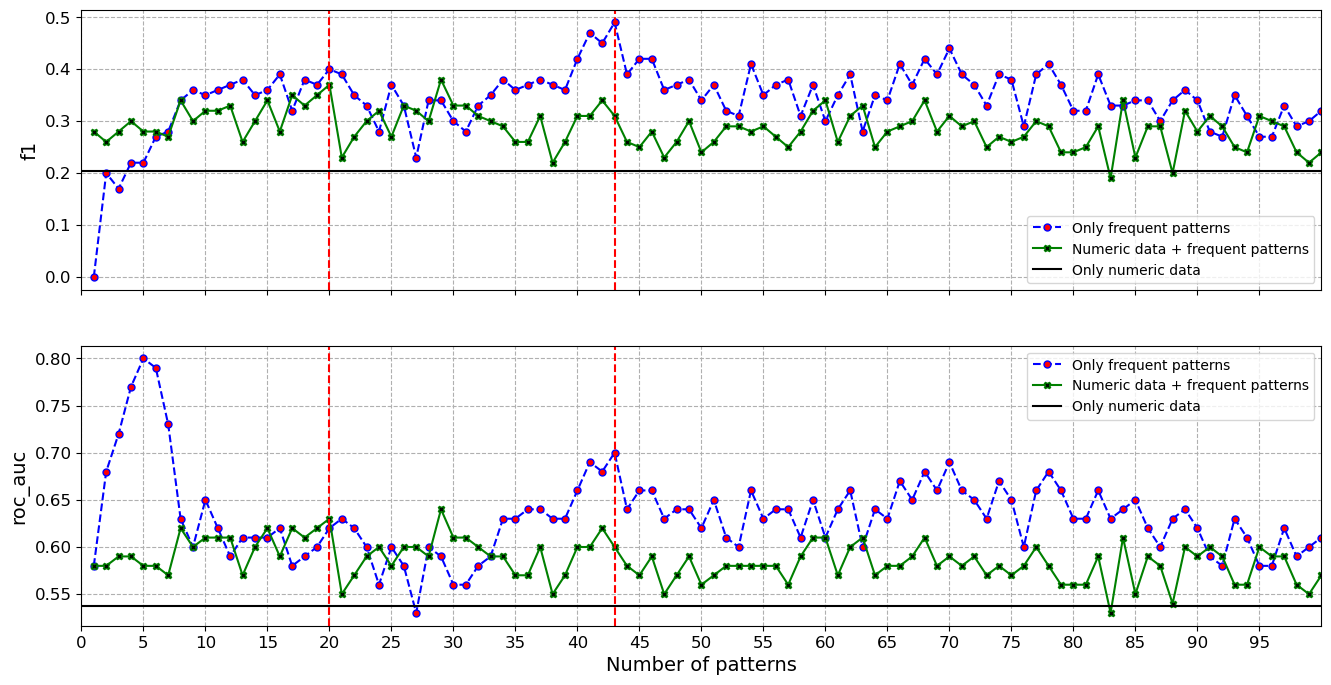

In [157]:
plt.style.use('default')
fig, ax = plt.subplots(2,1,figsize=(16,8),sharex=True)

ax[0].plot(f1.keys(),f1.values(),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5,label='Only frequent patterns')
ax[0].plot(f1_2.keys(),f1_2.values(),color='green', linestyle='-', marker='X',
         markerfacecolor='black', markersize=5,label='Numeric data + frequent patterns')


ax[1].plot(roc_auc.keys(),roc_auc.values(),color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5,label='Only frequent patterns')
ax[1].plot(roc_auc_2.keys(),roc_auc_2.values(),color='green', linestyle='-', marker='X',
         markerfacecolor='black', markersize=5,label='Numeric data + frequent patterns')

ax[0].axvline(x=20, color='red', linestyle='--')
ax[1].axvline(x=20, color='red', linestyle='--')
ax[0].axvline(x=43, color='red', linestyle='--')
ax[1].axvline(x=43, color='red', linestyle='--')
ax[0].axhline(y=np.mean(f1_means), color='black', linestyle='-', label='Only numeric data')
ax[1].axhline(y=np.mean(roc_auc_means), color='black', linestyle='-', label='Only numeric data')

ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('f1',fontsize=14)
ax[1].set_ylabel('roc_auc',fontsize=14)

ax[1].set_xticks(range(0, 100, 5))
ax[1].set_xlabel('Number of patterns',fontsize=14)

ax[0].set_xlim(left=0,right=100)
ax[1].set_xlim(left=0,right=100)

ax[0].grid(True, linestyle='--')
ax[1].grid(True, linestyle='--')

ax[0].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

fig.savefig('Experiment3_2.png',dpi=300)
plt.show()

A l'afegir patrons discriminatius al dataset original augmentem el *recall*, la qual cosa fa disminuïr l'*accuracy* i la *precision*, augmentar els encerts de nens obesos comporta augmentar els errors. El dataset numèric original té una *accuracy* d'aproximadament el 77% mentre que afegint patrons ens movem en valors d'entre el 76% i el 82%. D'altra banda, únicament amb el dataset original podem esperar un *recall* del 20-23% i afegint patrons l'augmentem fins al 30-40%.

Podem concloure doncs que afegir patrons freqüents rellevants augmenta el número de prediccions de la classe minoritaria o menys abundant i alhora augmenta el percentatge global d'encerts d'aquesta classe *recall*. No obstant també augmenten les prediccions fallides (instàncies de la classe majoritaria assignades a la minoritaria), la qual cosa repercuteix en una disminució en *precision*.

# Decoding dels patrons més discriminatius

A la llista *patterns* hi ha el llistat ordenat de patrons, mentre que a la llista *selected_features* hi ha els patrons més rellevants segons l'algorisme mrMr.

Apliquem regular expressions per obtenir l'índex de cada patró en datatype **integer**

In [89]:
# Regular expression pattern to match numerical values
pattern = r"\d+"

# Extract numerical values from each string
frequent_idx = []
for string in selected_features:
    matches = re.findall(pattern, string)
    frequent_idx.extend([int(match) for match in matches])

# Print the extracted numerical values
print(frequent_idx[:10])
print(len(frequent_idx))

[1886, 1073, 1981, 2529, 1204, 148, 876, 968, 1270, 1425]
200


A la llista **patterns**, l'índex correspon a l'índex del patró i al valor hi ha els ítems que composen cada patró. 

A partir de l'índex del patró accedim al llistat d'items que el composen.

In [90]:
frequent_list = list(map(lambda i: patterns[i], frequent_idx))
print(frequent_list[0])
frequent_list[0] == patterns[1886]

[282, 101, 43]


True

In [91]:
decoding={}
decoding[1]='ageM<=25'
decoding[2]='25<ageM<=30'
decoding[3]='30<ageM<=35'
decoding[4]='35<ageM'
decoding[11]='talla_EM<=159'
decoding[12]='159<talla_EM<=163'
decoding[13]='163<talla_EM<=167'
decoding[14]='167<talla_EM'
decoding[21]='tabac_preM==0'
decoding[22]='tabac_preM==1'
decoding[31]='alcohol_preM==0'
decoding[32]='alcohol_preM==1'
decoding[41]='BWM==1'
decoding[42]='BWM==2'
decoding[43]='BWM==3'
decoding[44]='BWM==4'
decoding[51]='Parity_EM==1'
decoding[52]='Parity_EM==2'
decoding[61]='BMIpre_mare<18.5'
decoding[62]='18.5<=BMIpre_mare<25'
decoding[63]='25<=BMIpre_mare<30'
decoding[64]='30<=BMIpre_mare'
decoding[71]='AgeP<=30'
decoding[72]='30<AgeP<=35'
decoding[73]='35<AgeP<=40'
decoding[74]='40<=AgeP'
decoding[81]='HeightP<=170'
decoding[82]='170<HeightP<=175'
decoding[83]='175<HeightP<=180'
decoding[84]='180<HeightP'
decoding[91]='BMI_P<18.5'
decoding[92]='18.5<=BMI_P<25'
decoding[93]='25<=BMI_P<30'
decoding[94]='30<=BMI_P'
decoding[101]='SmokingP==0'
decoding[102]='SmokingP==1'
decoding[111]='AlcoholP==0'
decoding[112]='AlcoholP==1'
decoding[121]='BWP==1'
decoding[122]='BWP==2'
decoding[123]='BWP==3'
decoding[124]='BWP==4'
decoding[131]='BMI_2_EM<24'
decoding[132]='24<=BMI_2_EM<26'
decoding[133]='26<=BMI_2_EM<28.5'
decoding[134]='28.5<=BMI_2_EM'
decoding[141]='tas_2_EM<104'
decoding[142]='104<=tas_2_EM<113'
decoding[143]='113<=tas_2_EM<121'
decoding[144]='121<=tas_2_EM'
decoding[151]='tad_2_EM<60'
decoding[152]='60<=tad_2_EM<65'
decoding[153]='65<=tad_2_EM<72'
decoding[154]='72<=tad_2_EM'
decoding[161]='BMI_3_EM<25.5'
decoding[162]='25.5<=BMI_3_EM<28'
decoding[163]='28<=BMI_3_EM<30.5'
decoding[164]='30.5<=BMI_3_EM'
decoding[171]='tas_3_EM<106'
decoding[172]='106<=tas_3_EM<114'
decoding[173]='114<=tas_3_EM<123'
decoding[174]='123<=tas_3_EM'
decoding[181]='tad_3_EM<64'
decoding[182]='64<=tad_3_EM<70'
decoding[183]='70<=tad_3_EM<76'
decoding[184]='76<=tad_3_EM'
decoding[191]='Obes_gest==0'
decoding[192]='Obes_gest==1'
decoding[201]='tabac_gestM==0'
decoding[202]='tabac_gestM==1'
decoding[211]='Sexe_nen==1'
decoding[212]='Sexe_nen==0'
decoding[221]='EG<=36'
decoding[222]='36<EG<=39'
decoding[223]='39<EG<=40'
decoding[224]='40<=EG'
decoding[231]='weight_B<=3000'
decoding[232]='3000<weight_B<=3500'
decoding[233]='3500<weight_B<=4000'
decoding[234]='4000<=weight_B'
decoding[241]='Height_B<48'
decoding[242]='48<=Height_B<50'
decoding[243]='50<=Height_B<51'
decoding[244]='51<=Height_B'
decoding[251]='pes placenta<500'
decoding[252]='500<=pes placenta<580'
decoding[253]='580<=pes placenta<660'
decoding[254]='660<=pes placenta'
decoding[261]='alimentacio<4'
decoding[262]='4<=alimentacio<7'
decoding[263]='alimentacio==7'
decoding[264]='7<alimentacio'
decoding[271]='pes2m<4900'
decoding[272]='4900<=pes2m<5300'
decoding[273]='5300<=pes2m<5650'
decoding[274]='5650<=pes2m'
decoding[281]='alt2m<56'
decoding[282]='56<=alt2m<58'
decoding[283]='58<=alt2m<59'
decoding[284]='59<=alt2m'
decoding[291]='pes4m<6200'
decoding[292]='6200<=pes4m<6750'
decoding[293]='6750<=pes4m<7300'
decoding[294]='7300<=pes4m'
decoding[301]='alt4m<62'
decoding[302]='62<=alt4m<=63'
decoding[303]='63<alt4m<65'
decoding[304]='65<=alt4m'
decoding[311]='pes6m<7100'
decoding[312]='7100<=pes6m<7700'
decoding[313]='7700<=pes6m<8350'
decoding[314]='8350<=pes6m'
decoding[321]='alt6m<66'
decoding[322]='66<=alt6m<67'
decoding[323]='67<=alt6m<68.5'
decoding[324]='68.5<=alt6m'
decoding[331]='pes12m<8925'
decoding[332]='8925<=pes12m<9650'
decoding[333]='9650<=pes12m<10325'
decoding[334]='10325<=pes12m'
decoding[341]='alt12m<73.5'
decoding[342]='73.5<=alt12m<75'
decoding[343]='75<=alt12m<77'
decoding[344]='77<=alt12m'

Executem el mapping:

In [92]:
discriminative_patterns = [[decoding[element] for element in sublist] for sublist in frequent_list]

In [93]:
print('Llistat del top 20 de patrons més discriminatius')
print('--------------------------------------------------------')
for i in range(20):
  if frequent_list[i] in obese:
    print('Patró {}, {}, Classe {}'.format(i+1,discriminative_patterns[i],'Obès'))
  else:
    print('Patró {}, {}, Classe {}'.format(i+1,discriminative_patterns[i],'Sa'))

Llistat del top 20 de patrons més discriminatius
--------------------------------------------------------
Patró 1, ['56<=alt2m<58', 'SmokingP==0', 'BWM==3'], Classe Obès
Patró 2, ['BWP==3', 'Obes_gest==0', 'talla_EM<=159'], Classe Sa
Patró 3, ['BWP==3', '28.5<=BMI_2_EM', 'Sexe_nen==0'], Classe Obès
Patró 4, ['AlcoholP==1', 'BWP==3', '8350<=pes6m', 'BWM==3'], Classe Obès
Patró 5, ['30<=BMI_P', 'Sexe_nen==1'], Classe Obès
Patró 6, ['BWP==3', 'tabac_gestM==0', '5300<=pes2m<5650'], Classe Obès
Patró 7, ['tabac_preM==0', '39<EG<=40', 'alcohol_preM==0'], Classe Obès
Patró 8, ['tabac_preM==0', 'HeightP<=170', 'Obes_gest==0'], Classe Obès
Patró 9, ['660<=pes placenta', 'BWP==3', 'Obes_gest==0', 'BWM==3'], Classe Obès
Patró 10, ['72<=tad_2_EM', '8350<=pes6m'], Classe Obès
Patró 11, ['25<=BMI_P<30', '4<=alimentacio<7'], Classe Obès
Patró 12, ['9650<=pes12m<10325', 'SmokingP==0'], Classe Obès
Patró 13, ['25<=BMI_P<30', '28.5<=BMI_2_EM', 'Sexe_nen==0'], Classe Obès
Patró 14, ['AlcoholP==1', '163<t

Dels 20 patrons més discriminatius, 19 són característics dels nens OBESOS i 2 dels Sans.

# SHAP values

In [22]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Carreguem el dataset discretitzat

In [2]:
data=pd.read_csv('output_d.csv')
data.head()

,AgeM,talla_EM,tabac_preM,alcohol_preM,BWM,Parity_EM,BMIpre_mare,AgeP,HeightP,BMI_P,...,mesos alim_mat_nen,Pes 2m_nen,Alçada 2m_nen,Pes 4m_nen,Alçada 4m_nen,pes 6m_nen,alçada 6m_nen,pes 12m_nen,alçada 12m_nen,OBE1TY_5Y_grup
0,3,12,21,31,43,51,63,74,83,93,...,264,274,282,293,302,312,323,333,341,1
1,1,13,22,31,42,51,62,71,82,92,...,261,272,282,292,301,312,322,332,342,0
2,2,14,21,31,43,51,63,74,83,93,...,261,272,284,293,304,313,324,333,344,0
3,4,12,21,31,43,52,62,74,83,94,...,264,272,283,293,303,313,323,334,344,1
4,3,13,21,31,43,51,62,73,84,92,...,262,272,283,292,302,312,323,332,342,0


In [10]:
X=data[data.columns[:-1]]
y=data[data.columns[-1]]

DecisionTreeClassifier

In [155]:
model2 = DecisionTreeClassifier(random_state=42).fit(X, y)
explainer2 = shap.Explainer(model2)
shap_values2 = explainer2(X)
print(shap_values2.shape)

(386, 35, 2)


In [156]:
shap_values2[:,:,1].shape

(386, 35)

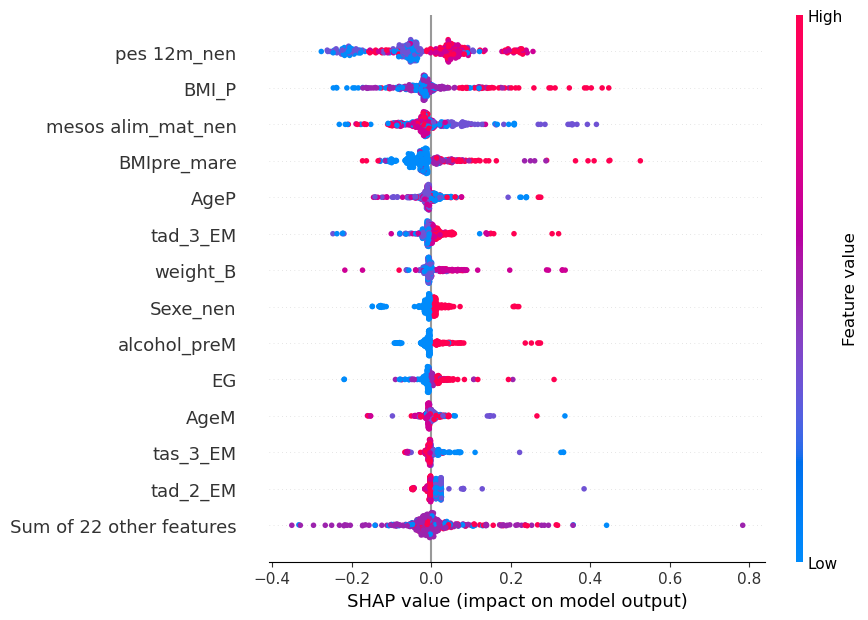

In [159]:
shap.plots.beeswarm(shap_values2[:,:,1],max_display=14)